In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt

## Waiting time from state probabilities

##### Theoretical waiting times (for inifinite queue size and infinite threshold)

In [2]:
def probability_no_people_in_the_system(traffic_intensity, num_of_servers):
    denominator = 0
    for i in range(num_of_servers):
        denominator += ((num_of_servers * traffic_intensity) ** i) / math.factorial(i)
    denominator += ((num_of_servers * traffic_intensity) ** num_of_servers) / (math.factorial(num_of_servers) * (1 - traffic_intensity))
    return 1 / denominator

In [3]:
def get_theoretical_waiting_time(Lambda, mu, num_of_servers):
    traffic_intensity = Lambda / (num_of_servers * mu)
    prob_0 = probability_no_people_in_the_system(traffic_intensity, num_of_servers)

    wait = ((num_of_servers * traffic_intensity) ** num_of_servers) / (math.factorial(num_of_servers) * mu * num_of_servers * (1 - traffic_intensity) ** 2)
    wait *= prob_0
    
    return wait

###### Waiting times from simulated state probabiliteis - Considering only other arrivals

*Waiting States:*

$$ S_w = \{ (u,v) \in S \; | \; v \geq C \} $$

In [4]:
def is_waiting_state(state, num_of_servers):
    return (True if state[1] >= num_of_servers else False)

*Accepting States (for other arrivals):*

$$ S_A = \{ (u,v) \in S \; | \; v < M \} $$

In [343]:
def is_accepting_state_other(state, system_capacity):
    return (True if state[1] < system_capacity else False)

*Expected waiting time in a state (when ignoring arrivals):*

$$ c(u,v) = \frac{1}{min(v,C) \mu} $$

In [236]:
def expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)

*Probability of a transition at state (u,v) being a service:*

$$ P_s(u,v) = \frac{\text{min}(v,C)\mu}{\text{min}(1, N - v)\lambda^o + \text{ min}(1, M - u)\lambda_A + \text{ min}(v,C)\mu} $$

$$ P_s(u,v) = 1 $$

In [405]:
def probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity):
    
    return 1
    ambulance_rate = min(1, parking_capacity - state[0]) * lambda_a
    others_rate = min(1, system_capacity - state[1]) * lambda_o
    service_rate = min(state[1], num_of_servers) * mu
    total_rate = ambulance_rate + others_rate + service_rate

    return service_rate / total_rate

*Waiting time of an individual when arriving at state (u,v):*

$$ 
w(u,v) = 
\begin{cases} 
    0, \hspace{4.85cm} \textbf{if } v < C \\
    c(u,v) + P_s w(u-1, v), \hspace{1cm} \textbf{if } u \geq 1 \textbf{ and } v = t \\
    c(u,v) + P_s w(u, v-1), \hspace{1cm} \textbf{otherwise} \\
\end{cases}
$$

In [406]:
def get_recursive_waiting_time(state, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    if not is_waiting_state(state, num_of_servers):
        return 0
    wait = expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu)
    if state[0] >= 1 and state[1] == threshold:
        wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time((state[0] - 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        return wait
    
    wait += probability_of_service(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity) * get_recursive_waiting_time((state[0], state[1] - 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return wait

*Mean Waiting Time:*

$$ W = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; w(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [411]:
def mean_waiting_time_formula(all_states, pi, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    mean_waiting_time = 0
    probability_of_accepting = 0
    for u, v in all_states:
        if is_accepting_state_other((u,v), system_capacity):
            current_state_wait = get_recursive_waiting_time((u,v), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
            mean_waiting_time += current_state_wait * pi[u,v]
            probability_of_accepting += pi[u,v]
#             print((u,v), current_state_wait, pi[u,v])
    mean_waiting_time /= probability_of_accepting
    return mean_waiting_time

*Main function:*

In [228]:
def get_mean_waiting_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num, num_of_trials):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
    all_states = [(u,v) for v in range(state_probabilities.shape[1]) for u in range(state_probabilities.shape[0]) if state_probabilities[u,v] > 0]
    mean_waiting_time = mean_waiting_time_formula(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

###### Waiting times from markov state probabiliteis

In [229]:
def get_mean_waiting_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    transition_matrix = abg.markov.get_transition_matrix(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    pi = abg.markov.get_steady_state_algebraically(transition_matrix, algebraic_function=np.linalg.solve)
    all_states = abg.markov.build_states(threshold, system_capacity, parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(pi, all_states, output=np.ndarray)
    mean_waiting_time = mean_waiting_time_formula(all_states, state_probabilities, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return mean_waiting_time

## Comparing Results

In [396]:
lambda_a = 0.0001
lambda_o = 0.3
mu = 0.4
num_of_servers = 1
threshold = 2
system_capacity = 5
parking_capacity = 0

num_of_trials = 10
seed_num = 0
runtime = 10000

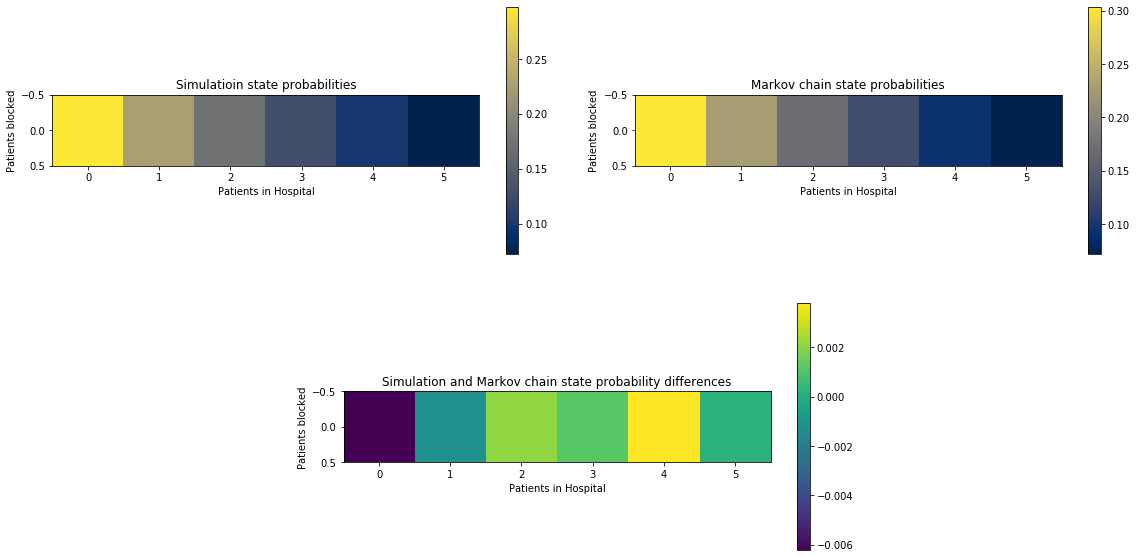

In [397]:
plt.figure(figsize=(20,10))
abg.get_heatmaps(lambda_a=lambda_a, lambda_o=lambda_o, mu=mu, num_of_servers=num_of_servers, threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity, seed_num=seed_num, runtime=runtime, num_of_trials=num_of_trials)

##### Simulated waiting time

In [407]:
times = abg.simulation.get_multiple_runs_results(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials=num_of_trials, seed_num=seed_num, runtime=runtime, system_capacity=system_capacity, parking_capacity=parking_capacity)
mean_waiting_time = np.mean([np.mean(w.waiting_times) for w in times])
print(mean_waiting_time)

4.277067209302156


##### Waiting time from simulated state probabilities

In [408]:
get_mean_waiting_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)

(0, 0) 0 0.28454200555261316
(0, 1) 2.5 0.2205021079974403
(0, 2) 5.0 0.1655702025084607
(0, 3) 7.5 0.1263300007544721
(0, 4) 10.0 0.08862574476629602
(0, 5) 12.5 0.06326048275210369
0.9488305443313859


4.219504519724247

###### Waiting time from markov state probabilities

In [409]:
get_mean_waiting_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

(0, 0) 0 0.28839564947555774
(0, 1) 2.5 0.21636883601903723
(0, 2) 5.0 0.16233071922328263
(0, 3) 7.5 0.12174803941746198
(0, 4) 10.0 0.09131102956309647
(0, 5) 12.5 0.06848327217232232
0.9486375458707582


4.253296949022159

In [418]:
all_times_sim = []
all_mean_times_sim = []
all_mean_times_markov = []
min_sys_cap = 1
max_sys_cap = 10
sys_cap_space = np.linspace(min_sys_cap, max_sys_cap, max_sys_cap - min_sys_cap + 1, dtype=int)
for system_capacity in sys_cap_space:
    system_capacity = int(system_capacity)

    times = abg.simulation.get_multiple_runs_results(lambda_a, lambda_o, mu, num_of_servers, threshold, num_of_trials=num_of_trials, seed_num=seed_num, runtime=runtime, system_capacity=system_capacity, parking_capacity=parking_capacity)
    simulation_waiting_times = [np.mean(w.waiting_times) for w in times]
    
    mean_waiting_time_sim = get_mean_waiting_time_simulation(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)
    mean_waiting_time_markov = get_mean_waiting_time_markov(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    
    all_times_sim.append(simulation_waiting_times)
    all_mean_times_sim.append(mean_waiting_time_sim)
    all_mean_times_markov.append(mean_waiting_time_markov)

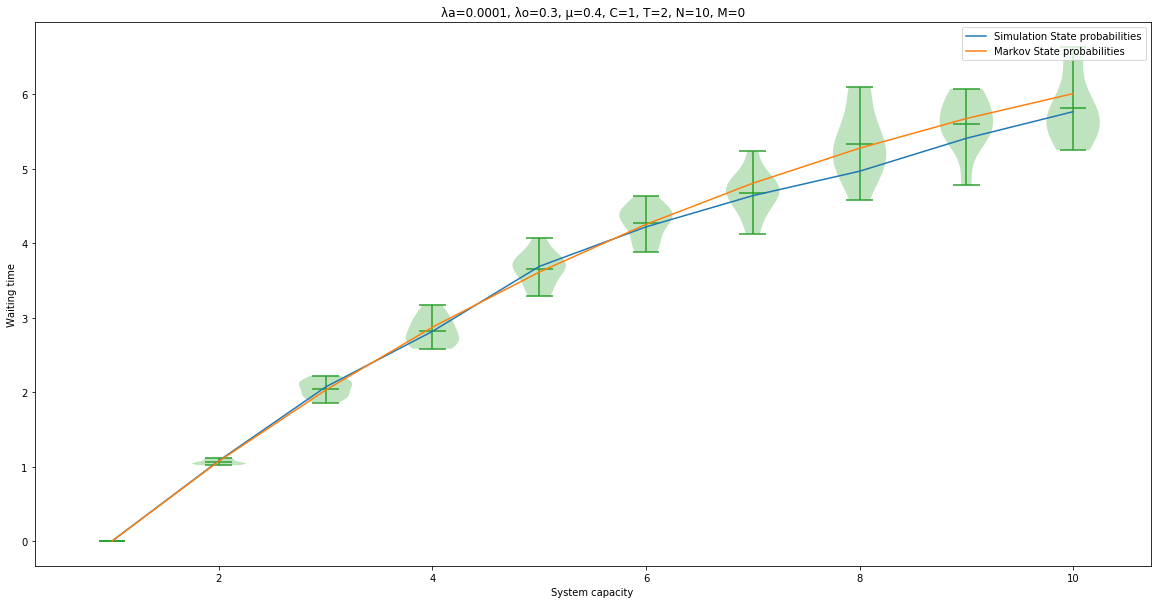

In [422]:
plt.figure(figsize=(20,10))
plt.plot(sys_cap_space, all_mean_times_sim, label="Simulation State probabilities")
plt.plot(sys_cap_space, all_mean_times_markov, label="Markov State probabilities")
plt.violinplot(all_times_sim, showmeans=True, showmedians=False)
title = "λa=" + str(lambda_a) + ", λo=" +str(lambda_o) + ", μ=" + str(mu) + ", C=" + str(num_of_servers) + ", T=" + str(threshold) + ", N=" + str(system_capacity) + ", M=" + str(parking_capacity)
plt.title(title)
plt.xlabel("System capacity")
plt.ylabel("Waiting time")
plt.legend()
plt.show()

##### Theoretical waiting time (valid for infinite system size and threshold)

In [269]:
waiting_time= get_theoretical_waiting_time(lambda_a + lambda_o, mu, num_of_servers)
print(waiting_time)

0.16666666666666666


###### Failed Attempt 1

In [8]:
def is_waiting_state(state, num_of_servers):
    return (True if state[1] > num_of_servers else False)

def expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)

In [9]:
def recursive_waiting_time_at_each_state(state, mu, num_of_servers, threshold):
    if not is_waiting_state(state, num_of_servers):
        return 0
    if state[1] == threshold and state[0] > 0:
        return expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu) + recursive_waiting_time_at_each_state((state[0] - 1, state[1]), mu, num_of_servers, threshold)
    elif state[1] != threshold or state[0] == 0:
        return expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu) + recursive_waiting_time_at_each_state((state[0], state[1] - 1), mu, num_of_servers, threshold)

In [10]:
def get_mean_waiting_time(all_states, pi, mu, num_of_servers, threshold):
    mean_waiting_time = 0
    for u, v in all_states:
        current_state_wait = recursive_waiting_time_at_each_state((u,v), mu, num_of_servers, threshold)
        mean_waiting_time += current_state_wait * pi[u,v]

#     mean_waiting_time /= probability_of_waiting
    return mean_waiting_time

In [11]:
state_probabilities = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)

In [12]:
state_probs_dict = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials, output=dict)
all_states = [state for state in state_probs_dict.keys() if state_probs_dict[state] > 0]

In [13]:
get_mean_waiting_time(all_states, state_probabilities, mu, num_of_servers, threshold)

1.0091220212215992

###### Failed Attempt 2

In [14]:
def is_waiting_state(state, num_of_servers):
    return (True if state[1] > num_of_servers else False)

def expected_time_in_markov_state(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity):
    return 1 / (min(state[1], num_of_servers) * mu + min(1, parking_capacity - state[0]) * lambda_a + min(1, system_capacity - state[1]) * lambda_o)

In [15]:
def transition_probs(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity):
    ambulance_rate = min(1, parking_capacity - state[0]) * lambda_a
    others_rate = min(1, system_capacity - state[1]) * lambda_o
    service_rate = min(state[1], num_of_servers) * mu
    total_rate = ambulance_rate + others_rate + service_rate
    
    return ambulance_rate / total_rate, others_rate / total_rate, service_rate / total_rate

In [16]:
def recursive_waiting_time(state, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity):
    
    depth = 0.001
    if not is_waiting_state(state, num_of_servers):
        return 0
    
    waiting_time = expected_time_in_markov_state(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity)
    ambulance_prob, others_prob, service_prob = transition_probs(state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity)
    
    if state[1] < threshold:
        if ambulance_prob + others_prob > depth:
            waiting_time += (ambulance_prob + others_prob) * recursive_waiting_time((state[0], state[1] + 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        if service_prob > depth:
            waiting_time += service_prob * recursive_waiting_time((state[0], state[1] - 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        return waiting_time
    
    if state[1] == threshold and state[0] != 0:
        if ambulance_prob > depth:
            waiting_time += ambulance_prob * recursive_waiting_time((state[0] + 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        if others_prob > depth:
            waiting_time += others_prob * recursive_waiting_time((state[0], state[1] + 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        if service_prob > depth:
            waiting_time += service_prob * recursive_waiting_time((state[0] - 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        return waiting_time
    
    if ambulance_prob > depth:
        waiting_time += ambulance_prob * recursive_waiting_time((state[0] + 1, state[1]), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    if others_prob > depth:
        waiting_time += others_prob * recursive_waiting_time((state[0], state[1] + 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    if service_prob > depth:
        waiting_time += service_prob * recursive_waiting_time((state[0], state[1] - 1), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
    return waiting_time

In [17]:
def get_mean_waiting_time(all_states, pi, mu, num_of_servers, threshold):
    mean_waiting_time = 0
    for u, v in all_states:
        current_state_wait = recursive_waiting_time((u,v), lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)
        mean_waiting_time += current_state_wait * pi[u,v]

    return mean_waiting_time

In [18]:
state_probabilities = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials)

In [19]:
state_probs_dict = abg.simulation.get_average_simulated_state_probabilities(lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity, seed_num=seed_num, num_of_trials=num_of_trials, output=dict)
all_states = [state for state in state_probs_dict.keys() if state_probs_dict[state] > 0]

In [57]:
get_mean_waiting_time(all_states, state_probabilities, mu, num_of_servers, threshold)

RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
for state in all_states:
    print(recursive_waiting_time(state, lambda_a, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity))

##### Failed Attempt 3

In [340]:
def get_wait(all_states, pi, num_of_servers, mu):
    mean_waiting_time = 0
    for u, v in all_states:
        if is_waiting_state((u,v), num_of_servers):
            exit_rate = (num_of_servers * mu)
            print(pi[u,v])
            mean_waiting_time += v * (1 / exit_rate) * pi[u,v]
    
#     mean_waiting_time /= probability_of_waiting
    return mean_waiting_time

In [341]:
get_wait(all_states, state_probabilities, num_of_servers, mu)

0.12630412679126404
0.06401389189147107
0.028053655238083407
0.016288983050045825


1.59577366364876